In [1]:
# Check GPU type
# !nvidia-smi

In [2]:
# Install ultralytics
# !pip -q install  ultralytics

In [3]:
from pathlib import Path
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [4]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [5]:
# Path to where your data is stored
DATA_DIR = Path('.')

# Preview data files available
os.listdir(DATA_DIR)

['data.yaml',
 'yolo11n.pt',
 'datasets',
 'train.csv',
 'yolo11m.pt',
 'requirements.txt',
 'test',
 '.gitignore',
 'training_notebook.ipynb',
 'sample_submission.csv',
 'train',
 'runs',
 '.git',
 'data_prep_notebook.ipynb']

In [6]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'train.csv')
# test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'sample_submission.csv')

# Add an image_path column
# train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
# test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['label'].map({'Jett': 0, 'Phoenix': 1, 'Sage': 2, 'Brimstone': 3})

# Preview the head of the train set
train.head()

,filename,filepath,width,height,depth,label,xmin,ymin,xmax,ymax,class_id
0,img_0028,train/images/img_0028.jpg,640,640,3,Jett,292,283,384,445,0
1,img_1336,train/images/img_1336.jpg,640,640,3,Jett,374,292,397,366,0
2,img_0996,train/images/img_0996.jpg,640,640,3,Phoenix,294,304,307,349,1
3,img_0996,train/images/img_0996.jpg,640,640,3,Jett,250,245,267,289,0
4,img_2159,train/images/img_2159.jpg,640,640,3,Phoenix,94,109,281,639,1


In [7]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['filename'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['label'], random_state=42)

X_train = train[train.filename.isin(X_train.filename)]
X_val = train[train.filename.isin(X_val.filename)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((2397, 11), (802, 11))

In [8]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['label'].value_counts(normalize = True), X_val['label'].value_counts(normalize = True)

(label
 Jett         0.339174
 Phoenix      0.292032
 Sage         0.198582
 Brimstone    0.170213
 Name: proportion, dtype: float64,
 label
 Jett         0.337905
 Phoenix      0.276808
 Sage         0.210723
 Brimstone    0.174564
 Name: proportion, dtype: float64)

In [9]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
    if DIR.exists():
        shutil.rmtree(DIR)
    DIR.mkdir(parents=True, exist_ok = True)

In [10]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.filepath.unique()):
    shutil.copy(img, TRAIN_IMAGES_DIR / img.split('/')[-1])

for img in tqdm(X_val.filepath.unique()):
    shutil.copy(img, VAL_IMAGES_DIR / img.split('/')[-1])

for img in tqdm(os.listdir(DATA_DIR / 'test/images')):
    shutil.copy(DATA_DIR / 'test/images' / img, TEST_IMAGES_DIR / img.split('/')[-1])

100%|██████████| 734/734 [00:00<00:00, 13907.06it/s]


In [11]:
# Function to convert the bboxes to yolo format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['filepath'], row['class_id'], row['output_dir']

    # img = cv2.imread(image_path)
    # if img is None:
    #     raise ValueError(f"Could not read image from path: {image_path}")

    height, width, _ = row['height'], row['width'], row['depth']

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    # with multiprocessing.Pool() as pool:
    #     list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))
    for row in tqdm(dataframe.to_dict('records'), total=len(dataframe)):
        save_yolo_annotation(row)

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

/tmp/ipykernel_69245/1866154514.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir
100%|██████████| 2397/2397 [00:00<00:00, 28076.43it/s]
/tmp/ipykernel_69245/1866154514.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir
100%|██████████| 802/802 [00:00<00:00, 24789.10it/s]


In [12]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [13]:
# # Create a data.yaml file required by yolo
# class_names = train['label'].unique().tolist()
# num_classes = len(class_names)
#
# data_yaml = {
#     'train': str(TRAIN_IMAGES_DIR),
#     'val': str(VAL_IMAGES_DIR),
#     'test': str(TEST_IMAGES_DIR),
#     'nc': num_classes,
#     'names': class_names
# }
#
# yaml_path = 'data.yaml'
# with open(yaml_path, 'w') as file:
#     yaml.dump(data_yaml, file, default_flow_style=False)
#
# # Preview data yaml file
# data_yaml

Plotting img_0004.jpg with 1 bounding boxes.


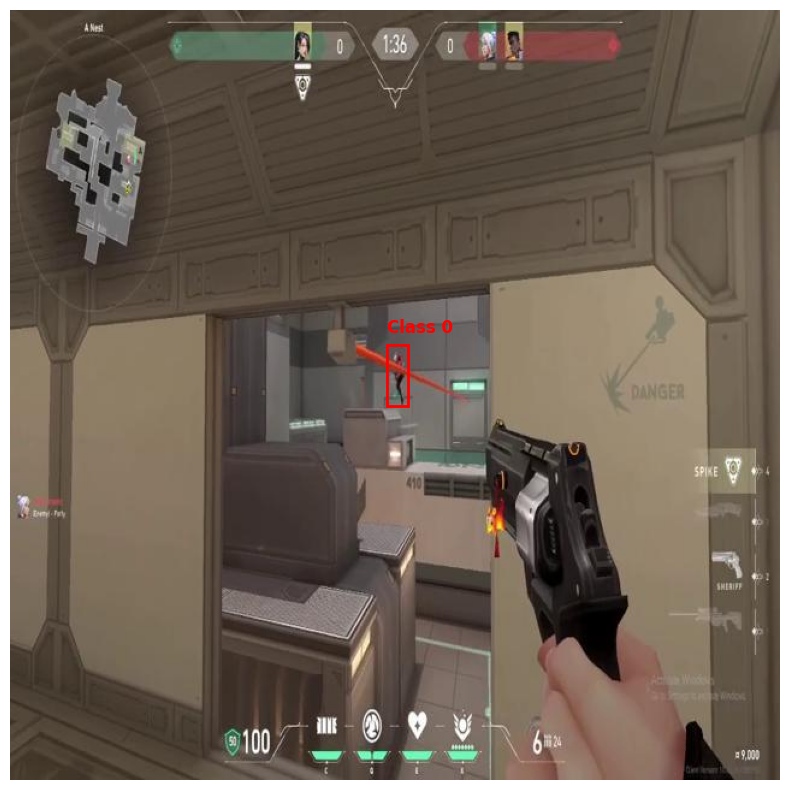

Plotting img_1763.jpg with 1 bounding boxes.


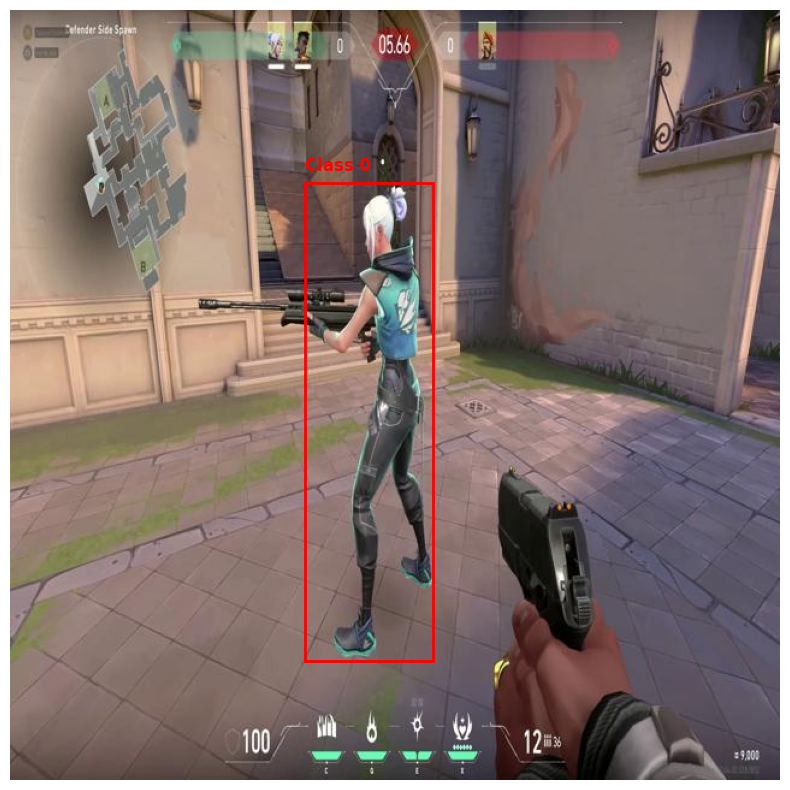

Plotting img_2595.jpg with 1 bounding boxes.


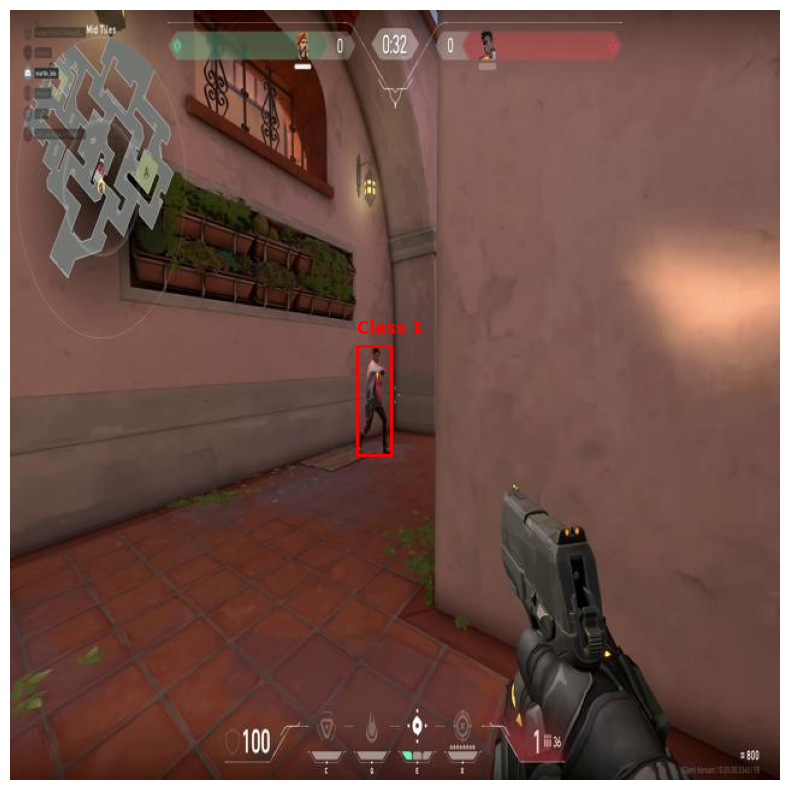

In [14]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [15]:
# Set the high watermark ratio to 0.0 (disabling the upper limit)
# os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [16]:
# Load a yolo pretrained model
model = YOLO('yolo11m.pt')

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=30,                 # Number of epochs
    imgsz=640,                # Image size (height, width)
    batch=20,                   # Batch size
    device='cuda',                  # Device to use (0 for the first GPU)
    patience=5)

Ultralytics 8.3.152 🚀 Python-3.12.11 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=20, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

train: Scanning /home/st3rniel/Developer/bookish-octo-sniffle/datasets/dataset/labels/train.cache... 1843 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1843/1843 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1039.4±928.7 MB/s, size: 49.6 KB)


val: Scanning /home/st3rniel/Developer/bookish-octo-sniffle/datasets/dataset/labels/val.cache... 615 images, 0 backgrounds, 0 corrupt: 100%|██████████| 615/615 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.00046875), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      9.65G      1.538      2.588      1.398          1        640: 100%|██████████| 93/93 [00:55<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

                   all        615        802      0.506      0.582      0.514      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      9.94G      1.657       1.81      1.524          5        640: 100%|██████████| 93/93 [00:52<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        615        802      0.215      0.364      0.154     0.0455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      9.89G      1.717      1.754      1.558          5        640: 100%|██████████| 93/93 [00:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all        615        802      0.656      0.295      0.346      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      9.93G      1.668      1.673       1.54          4        640: 100%|██████████| 93/93 [00:51<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.79it/s]

                   all        615        802      0.643       0.51      0.581      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      9.94G      1.641      1.587      1.533          9        640: 100%|██████████| 93/93 [00:51<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]

                   all        615        802      0.533       0.59      0.613      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      9.92G      1.599      1.464       1.48          5        640: 100%|██████████| 93/93 [00:51<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]

                   all        615        802       0.77      0.713      0.795      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      9.93G       1.53      1.306      1.437          8        640: 100%|██████████| 93/93 [00:50<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

                   all        615        802      0.791      0.797      0.858      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      9.93G      1.501      1.252      1.414          4        640: 100%|██████████| 93/93 [00:48<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]

                   all        615        802      0.744      0.733       0.81      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      9.93G      1.474      1.193        1.4          8        640: 100%|██████████| 93/93 [00:46<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        615        802      0.809      0.767      0.874       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.92G      1.449      1.142      1.397          4        640: 100%|██████████| 93/93 [00:48<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all        615        802      0.875      0.842      0.907      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      9.92G      1.457      1.107      1.382          8        640: 100%|██████████| 93/93 [00:48<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]

                   all        615        802      0.837      0.788      0.897      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      9.93G      1.389      1.049      1.357          3        640: 100%|██████████| 93/93 [00:46<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]

                   all        615        802      0.866      0.867      0.921      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      9.93G      1.382      1.033      1.359          8        640: 100%|██████████| 93/93 [00:47<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all        615        802      0.917      0.842      0.923      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      9.93G      1.381      0.992      1.353         10        640: 100%|██████████| 93/93 [00:47<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]

                   all        615        802       0.93      0.887      0.948      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      9.93G      1.359     0.9922      1.324          4        640: 100%|██████████| 93/93 [00:46<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]

                   all        615        802       0.88      0.848      0.919      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      9.93G      1.334     0.9509      1.311          3        640: 100%|██████████| 93/93 [00:47<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]

                   all        615        802      0.931      0.876      0.944      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      9.94G      1.317     0.9082        1.3          8        640: 100%|██████████| 93/93 [00:47<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


                   all        615        802      0.927       0.87      0.947      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      9.93G      1.326      0.898        1.3          8        640: 100%|██████████| 93/93 [00:49<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]

                   all        615        802      0.906      0.884      0.945      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      9.92G      1.276     0.8639      1.287          6        640: 100%|██████████| 93/93 [00:50<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]

                   all        615        802      0.948      0.894      0.956      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      9.93G       1.26     0.8339      1.256          7        640: 100%|██████████| 93/93 [00:49<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]

                   all        615        802      0.924      0.897       0.96      0.613


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      9.93G      1.223     0.7121       1.28          4        640: 100%|██████████| 93/93 [00:52<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

                   all        615        802      0.908      0.863      0.944      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      9.93G      1.185     0.6924      1.256          4        640: 100%|██████████| 93/93 [00:50<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]

                   all        615        802       0.93      0.893      0.955      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      9.92G      1.175     0.6518      1.238          3        640: 100%|██████████| 93/93 [00:51<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all        615        802      0.953      0.893      0.962      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      9.93G      1.119     0.6284      1.229          5        640: 100%|██████████| 93/93 [00:50<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

                   all        615        802      0.947      0.897      0.965      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      9.92G      1.111     0.6293      1.212          3        640: 100%|██████████| 93/93 [00:52<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]

                   all        615        802       0.94      0.906      0.968      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      9.93G      1.092     0.5974      1.204          3        640: 100%|██████████| 93/93 [00:49<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]

                   all        615        802      0.952      0.916       0.97      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      9.93G      1.084     0.5812      1.184          4        640: 100%|██████████| 93/93 [00:47<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        615        802      0.943      0.913      0.968       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      9.93G      1.055     0.5602      1.175          4        640: 100%|██████████| 93/93 [00:47<00:00,  1.95it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]

                   all        615        802      0.961      0.924      0.976       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      9.93G      1.029     0.5416      1.149          4        640: 100%|██████████| 93/93 [00:46<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]

                   all        615        802      0.958      0.921      0.974       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      9.91G      1.013     0.5278      1.145          4        640: 100%|██████████| 93/93 [00:47<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

                   all        615        802       0.96      0.932      0.978      0.665



30 epochs completed in 0.483 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.12.11 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


                   all        615        802       0.96      0.932      0.978      0.665
                  Jett        271        271      0.976       0.91      0.973      0.601
               Phoenix        222        222      0.954      0.973      0.985      0.721
                  Sage        169        169      0.956      0.897       0.97      0.638
             Brimstone        140        140      0.953       0.95      0.984      0.699
Speed: 0.3ms preprocess, 8.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f01847c6b40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [17]:
# inference
ss.head()

,Id,PredictionString
0,img_0032,Sage 269 297 320 446 Jett 594 322 635 477
1,img_0043,Phoenix 146 351 474 601


In [ ]:
# notes
# - some predictions might include more than 1 agent.
# - predictionString: name bbox_values *